In [ ]:
import pandas as pd
csv_data = pd.read_csv('contract_nft_counts.csv')
csv_data['Counts'] = csv_data['Counts'].astype(str)
non_numeric_counts = csv_data[~csv_data['Counts'].apply(lambda x: x.isdigit())]
print(non_numeric_counts)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os

In [3]:
directory = 'train_set'
files = os.listdir(directory)

In [4]:
jpg_files = [file for file in files if file.lower().endswith('.jpg')]
xml_files = [file for file in files if file.lower().endswith('.xml')]

In [5]:
jpg_files = sorted(jpg_files)[:10]
xml_files = sorted(xml_files)[:10]

## Filter the XML files such that only maize is labelled

In [8]:
import os
import shutil
import xml.etree.ElementTree as ET

source_dir = 'train_set/' 

new_dir = 'filtered_train_set/'  

if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# Filter objects in an XML file based on the label containing "ZEAMX"
def filter_xml_objects(xml_file_path, new_xml_file_path, label_contains='ZEAM', new_label='maize'):

    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    
    contains_required_label = False

    for obj in root.findall('object'):
        if label_contains in obj.find('name').text:
            # Change the label to the new label
            obj.find('name').text = new_label
            contains_required_label = True
        else:
            root.remove(obj)
            
    # If the XML contains at least one object with the required string in the label, save the modified XML
    if contains_required_label:
        tree.write(new_xml_file_path)
        return True
    else:
        return False

# List all XML files in the source directory
xml_files = [f for f in os.listdir(source_dir) if f.endswith('.xml')]

# Process each XML file
for xml_file in xml_files:
    xml_file_path = os.path.join(source_dir, xml_file)
    new_xml_file_path = os.path.join(new_dir, xml_file)
    
    # Filter the XML and change object names if needed
    if filter_xml_objects(xml_file_path, new_xml_file_path):
        # If the XML was saved, copy the corresponding image as well
        jpg_file = xml_file.replace('.xml', '.JPG')
        original_jpg_path = os.path.join(source_dir, jpg_file)
        new_jpg_path = os.path.join(new_dir, jpg_file)
        shutil.copy2(original_jpg_path, new_jpg_path)

print(f'Filtered XML files and images are saved in: {new_dir}')

Filtered XML files and images are saved in: filtered_train_set/


## Check the image size and it's frequency

In [3]:
import os
from PIL import Image
from collections import Counter
# Function to get image sizes and frequencies in a folder
def get_image_sizes_freq(folder_path):
    sizes_freq = Counter()
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith('.jpg'):
            try:
                # Open the image and get its size
                with Image.open(os.path.join(folder_path, file_name)) as img:
                    sizes_freq[img.size] += 1
            except IOError as e:
                print(f"Could not open {file_name} as an image. Error: {e}")
    return sizes_freq

your_folder_path = 'train_set'

image_sizes_and_freq = get_image_sizes_freq(your_folder_path)

# Print out the sizes and their frequencies
for size, freq in image_sizes_and_freq.items():
    print(f"Image size: {size}, Frequency: {freq}")

Image size: (3000, 1296), Frequency: 4368


## Downsize the images and their annotations

In [14]:
from PIL import Image
import xml.etree.ElementTree as ET

filtered_dir = 'filtered_train_set/'  

new_width = 256

def resize_image(image_path, new_width):
    with Image.open(image_path) as img:
        # Calculate the new height to maintain the aspect ratio
        wpercent = (new_width / float(img.size[0]))
        hsize = int((float(img.size[1]) * float(wpercent)))
        # Resize the image using the high-quality downsampling filter
        img = img.resize((new_width, hsize), Image.Resampling.LANCZOS)

        # Save the resized image
        img.save(image_path)


# Adjust bounding box values in the XML file
def adjust_bndbox(xml_file_path, scale_width, scale_height):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Adjust the bndbox values
    for bndbox in root.findall('.//bndbox'):
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Apply the scale to the bounding box coordinates
        bndbox.find('xmin').text = str(int(xmin * scale_width))
        bndbox.find('ymin').text = str(int(ymin * scale_height))
        bndbox.find('xmax').text = str(int(xmax * scale_width))
        bndbox.find('ymax').text = str(int(ymax * scale_height))

    tree.write(xml_file_path)

# Get the scale factor based on the first image (assuming all images have the same original size)
first_image_path = os.path.join(filtered_dir, os.listdir(filtered_dir)[0])
with Image.open(first_image_path) as first_img:
    original_width, original_height = first_img.size
    scale_width = new_width / original_width
    scale_height = scale_width  # Maintain the aspect ratio for height as well

# Process each file in the directory
for file in os.listdir(filtered_dir):
    file_path = os.path.join(filtered_dir, file)
    if file.lower().endswith('.jpg'):
        resize_image(file_path, new_width)
    elif file.lower().endswith('.xml'):
        adjust_bndbox(file_path, scale_width, scale_height)

print("Resizing of images and adjustment of XML files is complete.")

Resizing of images and adjustment of XML files is complete.


## Print the first 10 annotations
### fjfjoojfdsaopjkjopfjpoksffdsojakjofladsfm' - UBC mascot

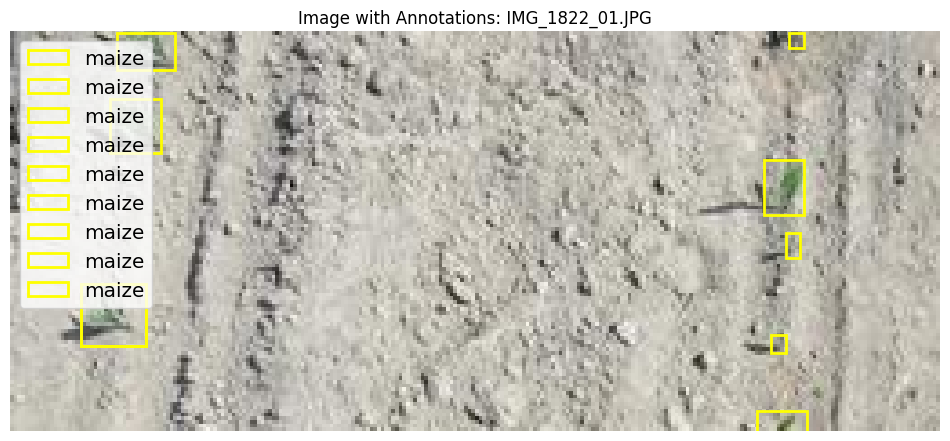

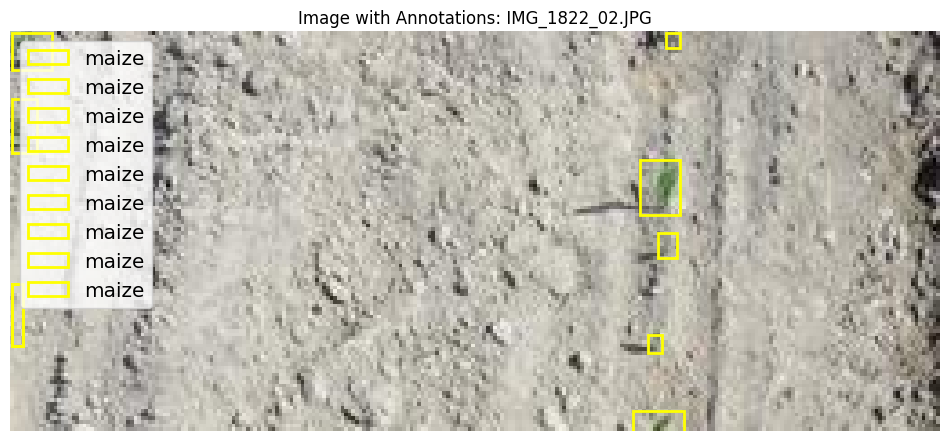

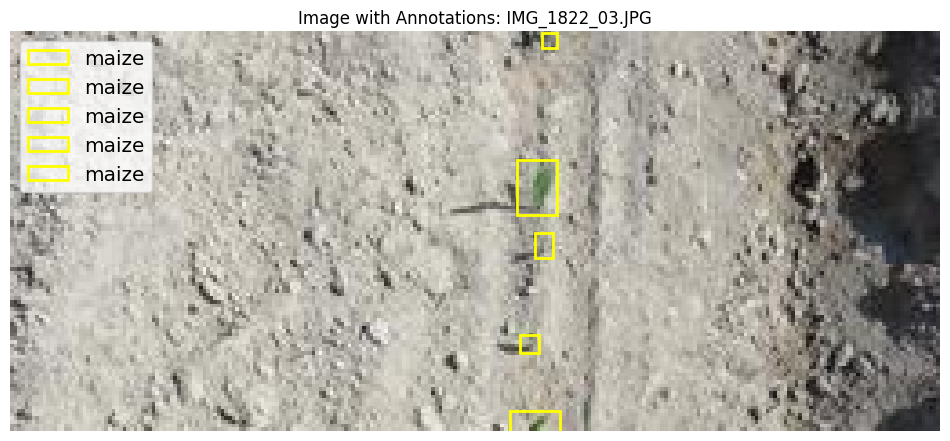

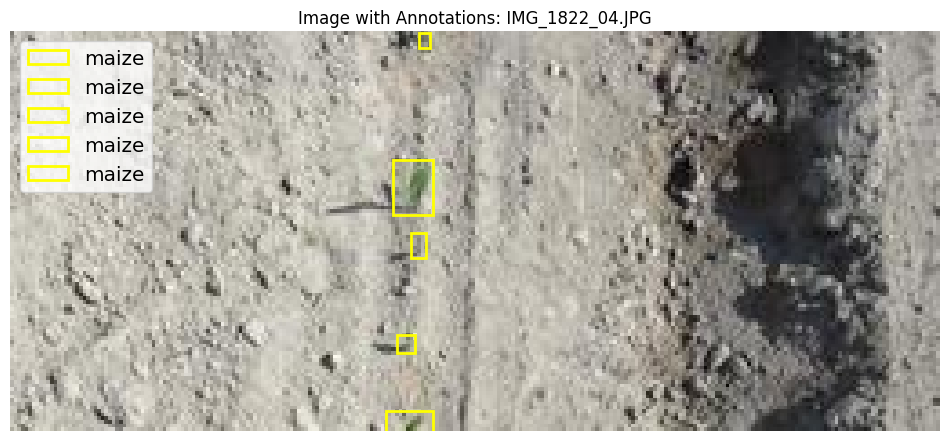

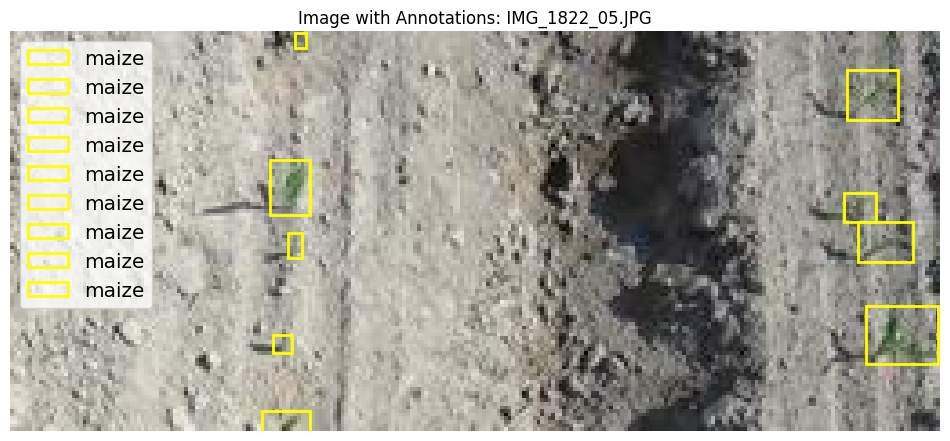

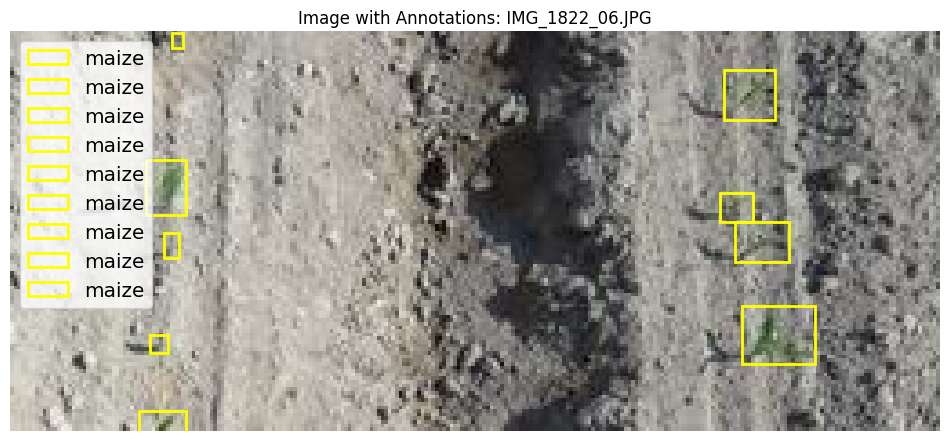

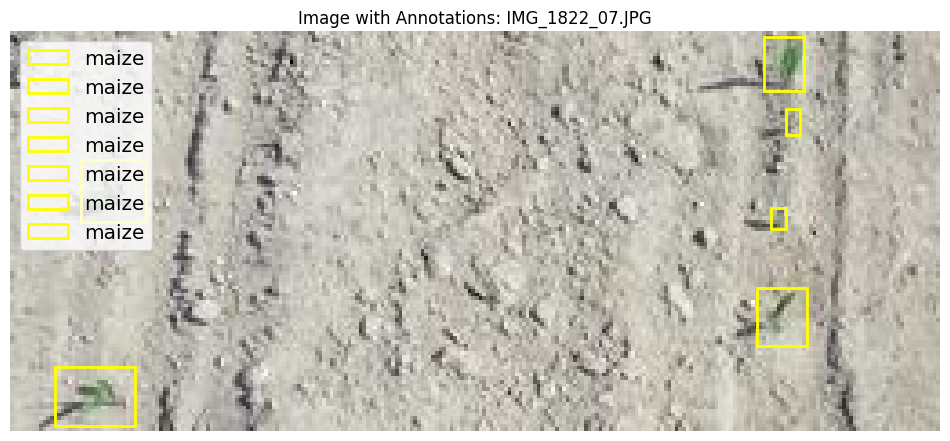

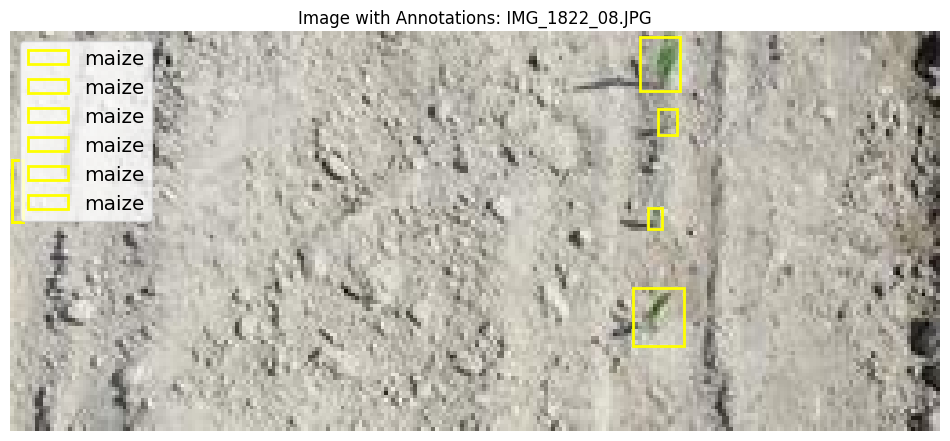

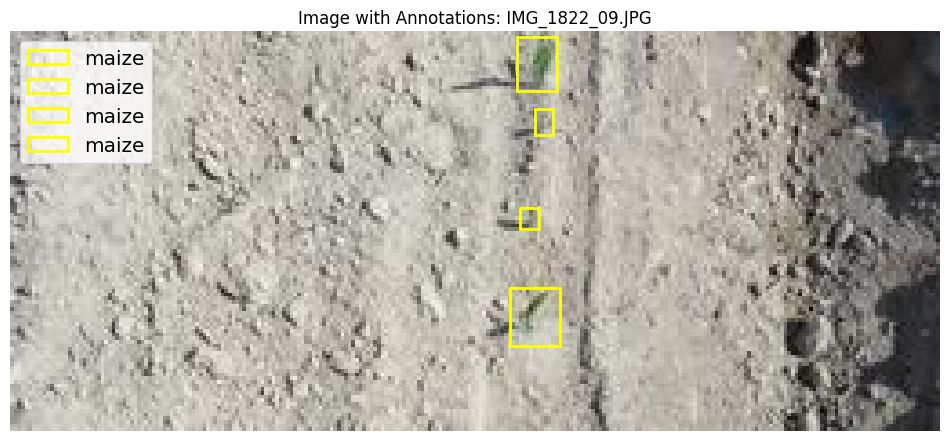

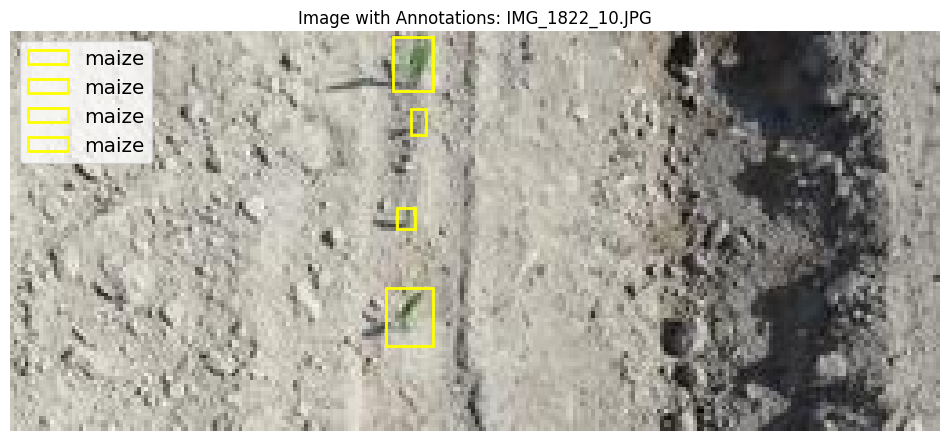

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import xml.etree.ElementTree as ET

resized_dir = 'filtered_train_set/'  

# Function to parse the XML file and get the bounding box annotations
def get_annotations_from_xml(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotations = []

    for member in root.findall('object'):
        bbox = member.find('bndbox')
        annotations.append({
            'label': member.find('name').text,
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        })
    return annotations

image_files = [f for f in sorted(os.listdir(resized_dir)) if f.endswith('.JPG') and os.path.isfile(os.path.join(resized_dir, f.replace('.JPG', '.xml')))]

# Plot the first 10 images with their annotations
for image_file in image_files[:10]:
    xml_file = image_file.replace('.JPG', '.xml')
    annotations = get_annotations_from_xml(os.path.join(resized_dir, xml_file))

    image_path = os.path.join(resized_dir, image_file)
    image = Image.open(image_path)

    fig, ax = plt.subplots(1, figsize=(12, 9))

    ax.imshow(image)

    for annotation in annotations:
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (annotation['xmin'], annotation['ymin']),
            annotation['xmax'] - annotation['xmin'],
            annotation['ymax'] - annotation['ymin'],
            linewidth=2,
            edgecolor='yellow',
            facecolor='none',
            label=annotation['label']
        )

        ax.add_patch(rect)

    plt.legend(loc='upper left', fontsize='x-large')
    plt.title(f"Image with Annotations: {image_file}")
    plt.axis('off') 
    plt.show()


## Don't look at this

In [ ]:
# from PIL import Image
# import os

# # Define the directory where the images are located
# images_dir = '/path/to/your/filtered_train_set/'  # Update this path to your actual directory

# # Load the background image for padding
# background_image_path = '/path/to/the/background_image.png'  # Update this path to the background image
# background_img = Image.open(background_image_path).convert("RGB")

# # Define the desired output size
# output_size = (256, 256)

# # Function to pad the image
# def pad_image(image_path, output_size, background_img):
#     # Open the original image
#     with Image.open(image_path) as img:
#         # Resize the background to the output size
#         background = background_img.resize(output_size)

#         # Calculate the position to place the original image on the background
#         width, height = img.size
#         x = (output_size[0] - width) // 2
#         y = (output_size[1] - height) // 2

#         # Paste the original image onto the background
#         background.paste(img, (x, y, x + width, y + height))

#         # Save the padded image
#         background.save(image_path)

# # Process each image in the directory
# for file in os.listdir(images_dir):
#     file_path = os.path.join(images_dir, file)
#     if file.lower().endswith('.jpg'):
#         pad_image(file_path, output_size, background_img)

# print("Padding of images is complete.")


In [3]:
# Let's read the XML file to extract the bounding box annotations
# and then pad the image accordingly without affecting the annotation coordinates.

# Load the annotation XML file
xml_file_path = 'filtered_train_set/IMG_1822_01.xml' 
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Define the target size for padding
target_size = (256, 256)

# Function to calculate the new padding to apply, taking into account the bounding boxes
def calculate_padding(image_size, target_size, annotations):
    # Calculate the required padding
    delta_width = target_size[0] - image_size[0]
    delta_height = target_size[1] - image_size[1]
    
    # Initialize padding values
    padding_top = padding_bottom = delta_height // 2
    padding_left = padding_right = delta_width // 2
    
    # Adjust the padding so that it doesn't overlap with any bounding boxes
    for ann in annotations:
        ymin = int(ann.find('bndbox/ymin').text)
        ymax = int(ann.find('bndbox/ymax').text)
        
        # If any bounding box is too close to the top, adjust the top padding
        if ymin < padding_top:
            padding_top = ymin
            padding_bottom = delta_height - padding_top
        
        # If any bounding box is too close to the bottom, adjust the bottom padding
        if image_size[1] - ymax < padding_bottom:
            padding_bottom = image_size[1] - ymax
            padding_top = delta_height - padding_bottom
    
    return padding_left, padding_top, padding_right, padding_bottom

# Extract the bounding box annotations
annotations = root.findall('.//object')

# Load the original image
image_path = 'filtered_train_set/IMG_1822_01.JPG'
original_image = Image.open(image_path)

# Calculate the padding values
padding_values = calculate_padding(original_image.size, target_size, annotations)

# Load the background image for padding
background_img_path = 'background image.png'
background_img = Image.open(background_img_path).convert("RGB")
background_img_resized = background_img.resize(target_size)

# Create a new image with the same size as the target size and paste the background
new_image = Image.new("RGB", target_size)
new_image.paste(background_img_resized, (0, 0))

# Paste the original image onto the new image using the calculated padding
new_image.paste(original_image, (padding_values[0], padding_values[1]))

# Save the result to a new file to display
output_image_path = 'padded_IMG_1822_01.jpg'
new_image.save(output_image_path)

# Display the padded image
new_image.show()

In [13]:
from PIL import Image

# Load the original image
image_path = 'filtered_train_set/IMG_1822_01.JPG'
original_image = Image.open(image_path)

# Load the background image
background_image_path = 'background image.png'
background_img = Image.open(background_image_path).convert("RGB")

# Desired output size
output_size = (256, 256)

# Calculate the new size for the image, maintaining aspect ratio
scale = output_size[0] / original_image.size[0]
new_size = (output_size[0], int(original_image.size[1] * scale))

# Resize the original image
resized_image = original_image.resize(new_size, Image.Resampling.LANCZOS)

# Resize the background image to the output size
background = background_img.resize(output_size)

# Calculate padding at the bottom
padding_bottom = output_size[1] - new_size[1]

# Paste the resized image onto the background, aligning to the bottom
background.paste(resized_image, (0, padding_bottom))

# Save the padded image
output_image_path = 'padded_IMG_1822_01.jpg'
background.save(output_image_path, 'JPEG')

print(f"Image saved to {output_image_path}")

Image saved to padded_IMG_1822_01.jpg


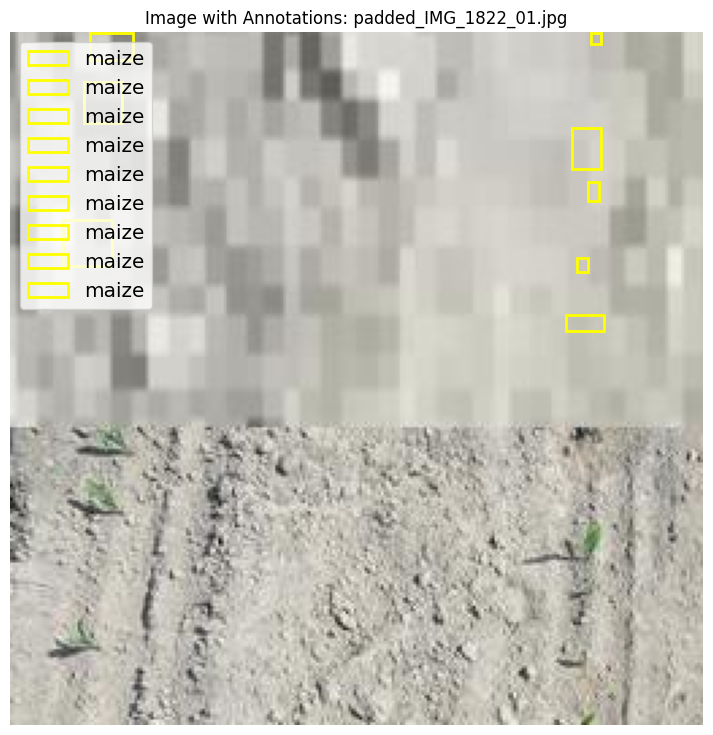

In [14]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import xml.etree.ElementTree as ET


# Function to parse the XML file and get the bounding box annotations
def get_annotations_from_xml(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotations = []

    for member in root.findall('object'):
        bbox = member.find('bndbox')
        annotations.append({
            'label': member.find('name').text,
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        })
    return annotations

image_file = 'padded_IMG_1822_01.jpg'


xml_file = 'padded_IMG_1822_01.xml'
annotations = get_annotations_from_xml(os.path.join(xml_file))

image_path = os.path.join(image_file)
image = Image.open(image_path)

fig, ax = plt.subplots(1, figsize=(12, 9))

ax.imshow(image)

for annotation in annotations:
    # Create a Rectangle patch
    rect = patches.Rectangle(
        (annotation['xmin'], annotation['ymin']),
        annotation['xmax'] - annotation['xmin'],
        annotation['ymax'] - annotation['ymin'],
        linewidth=2,
        edgecolor='yellow',
        facecolor='none',
        label=annotation['label']
    )

    ax.add_patch(rect)

plt.legend(loc='upper left', fontsize='x-large')
plt.title(f"Image with Annotations: {image_file}")
plt.axis('off') 
plt.show()

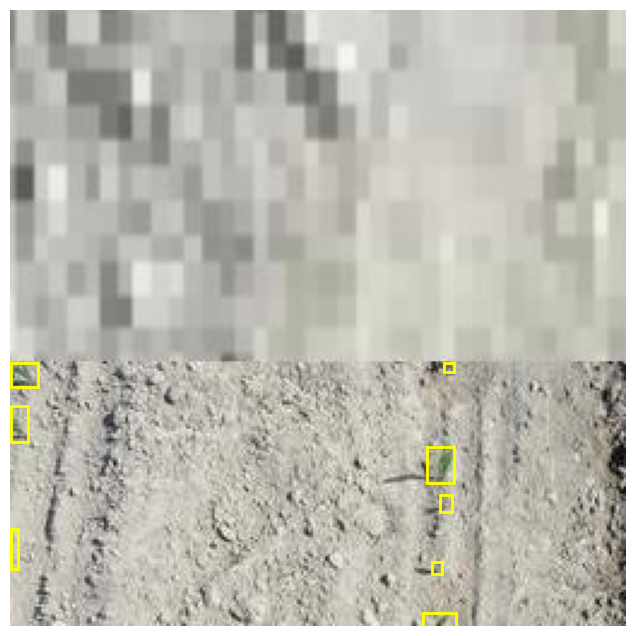

In [16]:
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the paths to your images and XML files
image_path = 'filtered_train_set/IMG_1822_02.JPG'
xml_file_path = 'filtered_train_set/IMG_1822_02.xml'
background_image_path = 'background image.png'  # Update this path to your actual background
output_image_path = 'padded_IMG_1822_02.jpg'

# Load the original image and background image
original_image = Image.open(image_path)
background_img = Image.open(background_image_path).convert("RGB")

# Desired output size
output_size = (256, 256)

# Calculate the new size for the image, maintaining aspect ratio
scale = output_size[0] / original_image.size[0]
new_size = (output_size[0], int(original_image.size[1] * scale))

# Resize the original image
resized_image = original_image.resize(new_size, Image.Resampling.LANCZOS)

# Resize the background image to the output size
background = background_img.resize(output_size)

# Calculate padding at the bottom
padding_bottom = output_size[1] - new_size[1]

# Paste the resized image onto the background, aligning to the bottom
background.paste(resized_image, (0, padding_bottom))

# Save the padded image
background.save(output_image_path, 'JPEG')

# Function to parse the XML file and get the bounding box annotations
def get_annotations_from_xml(xml_file_path, padding_bottom):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotations = []

    for member in root.findall('object'):
        bbox = member.find('bndbox')
        annotations.append({
            'label': member.find('name').text,
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text) + padding_bottom,  # Adjust for the padding
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text) + padding_bottom   # Adjust for the padding
        })
    return annotations

# Retrieve annotations adjusted for padding
annotations = get_annotations_from_xml(xml_file_path, padding_bottom)

# Plot the image and the annotations
fig, ax = plt.subplots(figsize=(8, 8))
image = Image.open(output_image_path)
ax.imshow(image)

# Draw the bounding boxes
for annotation in annotations:
    rect = patches.Rectangle(
        (annotation['xmin'], annotation['ymin']),
        annotation['xmax'] - annotation['xmin'],
        annotation['ymax'] - annotation['ymin'],
        linewidth=2,
        edgecolor='yellow',
        facecolor='none'
    )
    ax.add_patch(rect)

plt.axis('off')
plt.show()


In [19]:
from PIL import Image

# Load the original image
image_path = 'filtered_train_set/IMG_1822_01.JPG'  # Replace with your local path to the image
original_image = Image.open(image_path)

# Load the background image for padding
background_image_path = 'background image.png'  # Replace with your local path to the background image
background_img = Image.open(background_image_path).convert("RGB")

# Define the desired output size (256x256)
output_size = (256, 256)

# Calculate the new size for the image, maintaining aspect ratio
scale = output_size[0] / original_image.size[0]
new_size = (output_size[0], int(original_image.size[1] * scale))

# Resize the original image
resized_image = original_image.resize(new_size, Image.Resampling.LANCZOS)

# Resize the background image to match the output width and required padding height
background_resized_for_padding = background_img.resize((output_size[0], output_size[1] - new_size[1]))

# Create a new image with the desired size, paste the resized image at the top
new_image_with_bottom_padding = Image.new('RGB', output_size)
new_image_with_bottom_padding.paste(resized_image, (0, 0))

# Paste the resized background at the bottom to fill in the padding area
new_image_with_bottom_padding.paste(background_resized_for_padding, (0, new_size[1]))

# Save the bottom-padded image
output_image_path = 'bottom_padded_IMG_1822_01.jpg'  # Replace with your desired output path
new_image_with_bottom_padding.save(output_image_path)

print(f"Image saved to {output_image_path}")

Image saved to bottom_padded_IMG_1822_01.jpg
